# Librerias

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

seed = 42

# Lectura

In [3]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

# Bagging decision tree

Estimador base:

DecisionTreeClassifier(max_depth=10,
                        min_samples_leaf=10,
                        min_samples_split=65,
                        criterion='gini')

In [5]:
param_grid = {
    'n_estimators': [x for x in range(5,201,10)],
    'max_samples': list(np.arange(0.1,1.01,0.1))
}

kfold = KFold(n_splits=5,shuffle=True,random_state=seed)

grid_search_bg = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(max_depth=10,
                                                min_samples_leaf=10,
                                                min_samples_split=65,
                                                criterion='gini',
                                                random_state=seed),
                                                random_state = seed)
                            ,param_grid=param_grid
                            ,scoring='roc_auc'
                            ,cv=kfold
                            ,n_jobs=-1
                            ,verbose=0
                            ,return_train_score=True)

grid_search_bg.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                                          min_samples_leaf=10,
                                                                          min_samples_split=65,
                                                                          random_state=42),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'max_samples': [0.1, 0.2, 0.30000000000000004, 0.4,
                                         0.5, 0.6, 0.7000000000000001, 0.8, 0.9,
                                         1.0],
                         'n_estimators': [5, 15, 25, 35, 45, 55, 65, 75, 85, 95,
                                          105, 115, 125, 135, 145, 155, 165,
                                          175, 185, 195]},
             return_train_score=True, scoring='roc_auc')

In [6]:
print(f'Mejor modelo de Decision Tree cuenta con parametros: {grid_search_bg.best_estimator_}')
print(f'El AUC es de: {round(grid_search_bg.best_score_,3)}')

Mejor modelo de Decision Tree cuenta con parametros: BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                   min_samples_leaf=10,
                                                   min_samples_split=65,
                                                   random_state=42),
                  n_estimators=185, random_state=42)
El AUC es de: 0.881


In [22]:
grid_search_bg.best_estimator_.max_samples

1.0

# Visualizacion parametros

Train vs Test en validacion cruzada

In [7]:
n_estimators_list = list(grid_search_bg.cv_results_['param_n_estimators'].data)
max_samples_list = list(grid_search_bg.cv_results_['param_max_samples'].data)
mean_test_score_list = list(grid_search_bg.cv_results_['mean_test_score'])
mean_train_score_list = list(grid_search_bg.cv_results_['mean_train_score'])

bagging_df = pd.DataFrame(list(zip(n_estimators_list, max_samples_list, mean_train_score_list, mean_test_score_list)),
                                columns=['n_estimators', 'max_samples', 'mean_train_score', 'mean_test_score'])

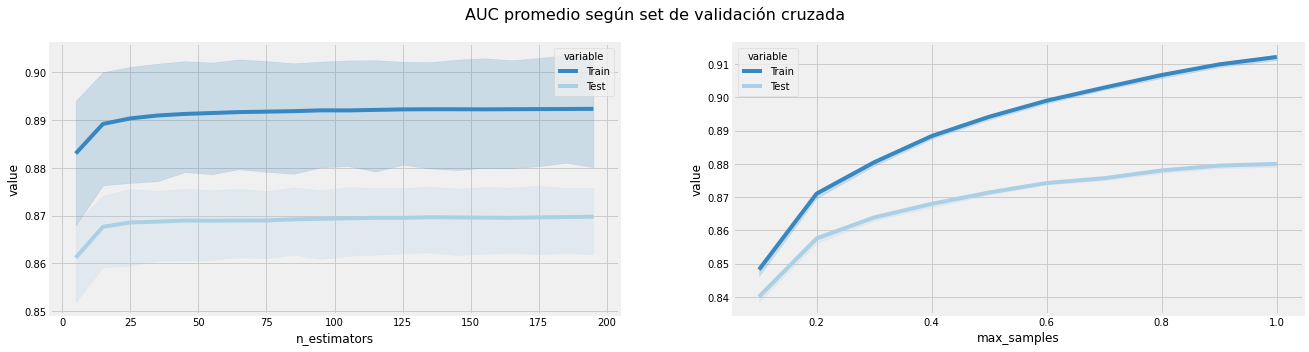

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
fig.suptitle("AUC promedio según set de validación cruzada", fontsize=16)

for i,param in enumerate(['n_estimators', 'max_samples']):
    df_melt = bagging_df.melt(id_vars=[param],value_vars= ['mean_train_score','mean_test_score'])
    df_melt.variable.replace({'mean_train_score':'Train',
                    'mean_test_score':'Test'},inplace=True)

    sns.lineplot(data=df_melt, x=param, y="value", hue="variable", ax=axes[i], palette ='Blues_r')

# Resultados CV test

In [9]:
results = cross_validate(
    grid_search_bg.best_estimator_,
    X_train,
    y_train,
    cv=kfold,
    scoring=['accuracy', 'precision', 'recall', "f1", "roc_auc"],
    return_train_score=False,
    n_jobs=-1
)

results_bg = pd.DataFrame(results)

In [21]:
mean_results = pd.DataFrame(results_bg.mean(axis=0), columns=['test_cv'])
mean_results

,test_cv
fit_time,0.67
score_time,0.06
test_accuracy,0.82
test_precision,0.78
test_recall,0.64
test_f1,0.70
test_roc_auc,0.88


In [11]:
mean_results.to_csv('../data/cv_results/bagging.csv', index=False)

# Resultados test

In [12]:
preds = grid_search_bg.predict(X_test)
print(classification_report(y_test,preds))
print(roc_auc_score(y_test,preds))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       603
           1       0.78      0.59      0.67       297

    accuracy                           0.81       900
   macro avg       0.80      0.75      0.77       900
weighted avg       0.81      0.81      0.80       900

0.754811799587919


# Guardamos modelo y resultados

In [13]:
resultados_dict = {
    'AUC': roc_auc_score(y_test,preds),
    'Accuracy': accuracy_score(y_test,preds),
    'Recall': recall_score(y_test,preds),
    'Precision': precision_score(y_test,preds),
    'F1_score': f1_score(y_test,preds)
}

In [14]:
resultados = pd.DataFrame(resultados_dict,index=['Resultados en test']).T

In [15]:
resultados

,Resultados en test
AUC,0.75
Accuracy,0.81
Recall,0.59
Precision,0.78
F1_score,0.67


In [16]:
resultados.to_csv('../data/resultados/bagging.csv',index=False)

In [17]:
import pickle
pickle.dump(grid_search_bg, open('../data/modelos/bagging.pkl', 'wb'))